# Homework ML Zoomcamp Week 6

## Moduls

In [52]:
# Import modules
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as mse

import xgboost as xgb

## Data

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from Kaggle or download using wget link mentioned below:

wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [2]:
# Use only the following columns:

cols = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',
        'median_income', 'median_house_value', 'ocean_proximity']

In [3]:
# Read data

data = 'https://raw.githubusercontent.com/katrinlaura73/MLZoomcamp/main/housing.csv'

df = pd.read_csv(data, usecols = cols)

# Check data
display(df.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data cleaning

Fill NAs with 0.

In [4]:
# fill NAs

df = df.fillna(0)

# check fill

df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Data preparation

Apply the log tranform to median_house_value.

Do train/validation/test split with 60%/20%/20% distribution.

Use the train_test_split function and set the random_state parameter to 1.

Use DictVectorizer to turn the dataframe into matrices.


In [5]:
display("Median_house_value before transformation:", df.median_house_value.describe())

# log transform
df.median_house_value = np.log1p(df.median_house_value)

# Check log transfrom
display("Median_house_value after transformation:", df.median_house_value.describe())

'Median_house_value before transformation:'

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

'Median_house_value after transformation:'

count    20640.000000
mean        12.084891
std          0.569131
min          9.615805
25%         11.691916
50%         12.099050
75%         12.486451
max         13.122367
Name: median_house_value, dtype: float64

In [6]:
# define seed
seed = 1

# train/test/val-split

df_train_full, df_test = train_test_split(df, test_size = 0.2, random_state=seed )
df_train, df_val = train_test_split(df_train_full, test_size = 0.25, random_state=seed)

# check split
display(len(df), len(df_train_full), len(df_test), len(df_train), len(df_val))

20640

16512

4128

12384

4128

In [7]:
# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Define target
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

# Delete target
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [8]:
# Make dicts

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

## Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

Which feature is used for splitting the data?

In [15]:
# Train decision tree regressor
dtr = DecisionTreeRegressor(max_depth=1, random_state=seed)

dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [48]:
features = list(dv.get_feature_names_out())
print(export_text(dtr, feature_names =features))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



The feature 'ocean_proximity=INLAND' is used for splitting the data.

## Question 2

Train a random forest model with these parameters:

n_estimators=10

random_state=1

n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=seed, n_jobs=-1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mse_rf = mse(y_val, y_pred)
rmse_rf = mse_rf **(1/2)

display('The RMSE of the radom forest model on validation is: ', round(rmse_rf,2))


'The RMSE of the radom forest model on validation is: '

0.25

## Question 3

Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.

Set random_state to 1.

Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

In [12]:
# make array
RMSE_n = []
n_array = np.arange(10, 210, step=10)

# try different n_estimators
for n in n_array:
    rf = RandomForestRegressor(n_estimators=n, random_state=seed, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse_rf = round(mse(y_val, y_pred) ** (1/2),3)
    RMSE_n.append((n, rmse_rf))
    
display(RMSE_n)

[(10, 0.246),
 (20, 0.239),
 (30, 0.236),
 (40, 0.235),
 (50, 0.233),
 (60, 0.233),
 (70, 0.232),
 (80, 0.233),
 (90, 0.232),
 (100, 0.232),
 (110, 0.232),
 (120, 0.232),
 (130, 0.232),
 (140, 0.232),
 (150, 0.232),
 (160, 0.232),
 (170, 0.232),
 (180, 0.232),
 (190, 0.232),
 (200, 0.232)]

RMSE stops improving after n_estimator = 50

## Question 4

Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]

For each of these values, try different values of n_estimators from 10 till 200 (with step 10)

Fix the random seed: random_state=1

What's the best max_depth?

In [14]:
# make array
RMSE_dn = []


# try different values of max_depth
for md in [10, 15, 20, 25]:
    # try different n_estimators
    for n in n_array:
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=seed, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse_rf = round(mse(y_val, y_pred) ** (1/2),3)
        RMSE_dn.append((n, md, rmse_rf))
    
display(RMSE_dn)

[(10, 10, 0.255),
 (20, 10, 0.253),
 (30, 10, 0.252),
 (40, 10, 0.251),
 (50, 10, 0.25),
 (60, 10, 0.25),
 (70, 10, 0.25),
 (80, 10, 0.25),
 (90, 10, 0.249),
 (100, 10, 0.249),
 (110, 10, 0.249),
 (120, 10, 0.249),
 (130, 10, 0.249),
 (140, 10, 0.249),
 (150, 10, 0.249),
 (160, 10, 0.249),
 (170, 10, 0.249),
 (180, 10, 0.249),
 (190, 10, 0.249),
 (200, 10, 0.249),
 (10, 15, 0.245),
 (20, 15, 0.239),
 (30, 15, 0.237),
 (40, 15, 0.236),
 (50, 15, 0.235),
 (60, 15, 0.235),
 (70, 15, 0.234),
 (80, 15, 0.234),
 (90, 15, 0.234),
 (100, 15, 0.234),
 (110, 15, 0.233),
 (120, 15, 0.233),
 (130, 15, 0.233),
 (140, 15, 0.233),
 (150, 15, 0.233),
 (160, 15, 0.233),
 (170, 15, 0.233),
 (180, 15, 0.233),
 (190, 15, 0.233),
 (200, 15, 0.233),
 (10, 20, 0.246),
 (20, 20, 0.239),
 (30, 20, 0.236),
 (40, 20, 0.235),
 (50, 20, 0.233),
 (60, 20, 0.233),
 (70, 20, 0.233),
 (80, 20, 0.233),
 (90, 20, 0.233),
 (100, 20, 0.232),
 (110, 20, 0.232),
 (120, 20, 0.232),
 (130, 20, 0.232),
 (140, 20, 0.232),
 (150

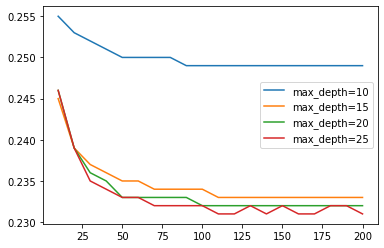

In [35]:
columns = [ 'n_estimators','max_depth', 'rmse']
df_scores = pd.DataFrame(RMSE_dn, columns=columns)
for d in [10, 15,20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend();

The best max_depth is 25.

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- n_estimators=10,
- nmax_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature?

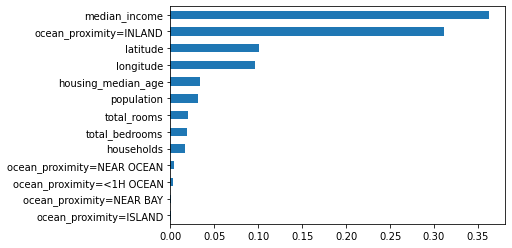

In [50]:
# train model with given parameters
rf = RandomForestRegressor(n_estimators=10, max_depth=20,random_state=seed, n_jobs=-1)
rf.fit(X_train, y_train)

# get features_importance
importance_rf = pd.Series(rf.feature_importances_, features)
sorted_importance_rf = importance_rf.sort_values()
sorted_importance_rf.plot(kind='barh');


The most important feature is median_income.


## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost

Create DMatrix for train and validation

Create a watchlist

Train a model with these parameters for 100 rounds:

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [51]:
# !pip install xgboost

In [64]:
# Preparate features names
features_new = [str.replace('<','') for str in features]
display(features_new)

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [70]:
# Create DMatrix
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features_new)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features_new)

# Create watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

#train a model
xgb_params = {'eta' : 0.3, 'max_depth':6, 'min_child_weight': 1, 'eval_metric': 'rmse',
            'objective': 'reg:squarederror', 'nthread': 8, 'seed': seed, 'verbosity':1}
              
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)
              
# predict          
y_pred = model.predict(dval)
# Calculate rmse
rmse_xgb = round(mse(y_val, y_pred) ** (1/2),3)
display('rmse_xgb with eta = 0.3:', rmse_xgb)

[0]	train-rmse:8.12733	val-rmse:8.13245
[1]	train-rmse:5.69586	val-rmse:5.70070
[2]	train-rmse:3.99540	val-rmse:4.00041
[3]	train-rmse:2.80712	val-rmse:2.81079
[4]	train-rmse:1.97834	val-rmse:1.98175
[5]	train-rmse:1.40218	val-rmse:1.40741
[6]	train-rmse:1.00099	val-rmse:1.00700
[7]	train-rmse:0.72751	val-rmse:0.73439
[8]	train-rmse:0.54190	val-rmse:0.55047
[9]	train-rmse:0.42167	val-rmse:0.43233
[10]	train-rmse:0.34481	val-rmse:0.35782
[11]	train-rmse:0.29835	val-rmse:0.31360
[12]	train-rmse:0.27095	val-rmse:0.28865
[13]	train-rmse:0.25268	val-rmse:0.27334
[14]	train-rmse:0.24295	val-rmse:0.26605
[15]	train-rmse:0.23555	val-rmse:0.26044
[16]	train-rmse:0.22630	val-rmse:0.25229
[17]	train-rmse:0.22233	val-rmse:0.24902
[18]	train-rmse:0.22029	val-rmse:0.24826
[19]	train-rmse:0.21791	val-rmse:0.24696
[20]	train-rmse:0.21580	val-rmse:0.24624
[21]	train-rmse:0.21160	val-rmse:0.24334
[22]	train-rmse:0.20975	val-rmse:0.24245
[23]	train-rmse:0.20904	val-rmse:0.24269
[24]	train-rmse:0.20703	va

'rmse_xgb with eta = 0.3:'

0.226

In [71]:
# Do the same with eta = 0.1
#train a model
xgb_params2 = {'eta' : 0.1, 'max_depth':6, 'min_child_weight': 1, 'eval_metric': 'rmse',
            'objective': 'reg:squarederror', 'nthread': 8, 'seed': seed, 'verbosity':1}
              
model2 = xgb.train(xgb_params2, dtrain, evals=watchlist, num_boost_round=100)
              
# predict          
y_pred2 = model2.predict(dval)
# Calculate rmse
rmse_xgb2 = round(mse(y_val, y_pred2) ** (1/2),3)
display('rmse_xgb with eta = 0.1:', rmse_xgb2)

[0]	train-rmse:10.44372	val-rmse:10.44938
[1]	train-rmse:9.40118	val-rmse:9.40684
[2]	train-rmse:8.46290	val-rmse:8.46831
[3]	train-rmse:7.61859	val-rmse:7.62391
[4]	train-rmse:6.85878	val-rmse:6.86368
[5]	train-rmse:6.17513	val-rmse:6.17987
[6]	train-rmse:5.55994	val-rmse:5.56437
[7]	train-rmse:5.00643	val-rmse:5.01061
[8]	train-rmse:4.50846	val-rmse:4.51264
[9]	train-rmse:4.06043	val-rmse:4.06461
[10]	train-rmse:3.65741	val-rmse:3.66135
[11]	train-rmse:3.29492	val-rmse:3.29877
[12]	train-rmse:2.96894	val-rmse:2.97284
[13]	train-rmse:2.67573	val-rmse:2.67979
[14]	train-rmse:2.41195	val-rmse:2.41587
[15]	train-rmse:2.17500	val-rmse:2.17928
[16]	train-rmse:1.96214	val-rmse:1.96662
[17]	train-rmse:1.77065	val-rmse:1.77536
[18]	train-rmse:1.59880	val-rmse:1.60396
[19]	train-rmse:1.44376	val-rmse:1.44910
[20]	train-rmse:1.30499	val-rmse:1.31054
[21]	train-rmse:1.18080	val-rmse:1.18646
[22]	train-rmse:1.06879	val-rmse:1.07469
[23]	train-rmse:0.96912	val-rmse:0.97546
[24]	train-rmse:0.87914	

'rmse_xgb with eta = 0.1:'

0.231

eta = 0.3 leads to the best RMSE.